# Optimal Chemical Kinetics: A Self-Driving Laboratory Approach
*By Marcus Schwarting*

__Goal:__ Develop an active learning strategy for optimizing a batch-process chemical reaction to produce a desired compound.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from scipy.stats import norm



In [ ]:
np.random.seed(0)
#### HIDDEN PARAMETERS ####
Arh_constant = 4e3 #unitless
catalysts_Ea_dict = {'None':{'Ea':np.random.uniform(9,11),'price':0},'alpha':{},'beta':{},'gamma':{}}
catalysts_Ea_dict['alpha']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['beta']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
catalysts_Ea_dict['gamma']['Ea'] = catalysts_Ea_dict['None']['Ea'] - np.random.uniform(0,2)
#Ea values are in units of kJ/mol
reaction_rate_noise = 0.2

#Note: we are doing everything in mols so we don't have to deal with conversions, densities, and other stuff.
measurement_techniques = {'low_fi':{'sigma':10},\
                          'mid_fi':{'sigma':5},\
                          'high_fi':{'sigma':1},\
                          'perfect':{'sigma':0,'time':0}} #NOTE: 'perfect' is not to be used in practice
#measurement sigmas are in units of mols

In [ ]:
#### KNOWN PARAMETERS ####

# aA + bB --> cX + dY
#Stoichiometric constants (selected so total number of mols does not change):
#a = np.random.choice(range(1,8))
#b = np.random.choice(range(1,8))
#d = np.random.choice(range(1,4))
#c = a+b-d
a = 3
b = 2
c = 1
d = 4

#Measurement Times
measurement_techniques['low_fi']['time']=0.2 #hours
measurement_techniques['mid_fi']['time']=0.5 #hours
measurement_techniques['high_fi']['time']=1 #hours

V = 1000 #Tank "volume", in mols
T_lower = 293 #Kelvin (room temperature)
T_upper = 800 #Kelvin
k_B = 8.314462618e-3 #Boltzmann's constant, kJ/(mol*K)

#Price of various compounds
P_A = np.random.uniform(-10,-5) #Cost to purchase A ($/mol), a negative cash flow
P_B = np.random.uniform(-10,-5) #Cost to purchase B ($/mol), a negative cash flow
P_X = np.random.uniform(50,100) #Sale price of X ($/mol), a positive cash flow
P_Y = np.random.uniform(-10,-5) #Cost to dispose of Y ($/mol), a negative cash flow

catalysts_Ea_dict['alpha']['price'] = np.random.uniform(100,300) #Cost of alpha ($)
catalysts_Ea_dict['beta']['price'] = np.random.uniform(100,300) #Cost of beta ($)
catalysts_Ea_dict['gamma']['price'] = np.random.uniform(100,300) #Cost of gamma ($)

#Price of heat
P_T = np.random.uniform(1,5) #Units of $ / (K * mol * hr). Note that this is not all that realistic...

t_min = 1
t_max = 10 #Maximum run time of ten hours on a batch

print(f'{a}A + {b}B --> {c}X + {d}Y')

3A + 2B --> 1X + 4Y


In [ ]:
#TODO: Break this into a separate script...? Depends on how this will be presented to students.
Arh_rate_k = lambda A, Ea, T: A*np.exp(-Ea/(k_B*T))

class Reactor:
    def __init__(self):
        self.interval = 0.01 #Working in time steps of a tenth of an hour, or six minutes
        self.load_time = 0.5
        self.purge_time = 0.5
        self.rxn_noise_sigma = 0.2

        self.quantity_A = []
        self.quantity_B = []
        self.quantity_X = []
        self.quantity_Y = []
        self.reactor_status_list = []
        self.cash_flow_list = []
        self.profit_per_hour_list = []
        return

    def _load_reactor(self,V_A,V_B,run_temp,run_time,catalyst_choice):
        load_interval = int(self.load_time/self.interval)
        heat_cost = (run_temp-T_lower)*run_time*P_T
        load_cost = (V_A*P_A) + (V_B*P_B) + catalysts_Ea_dict[catalyst_choice]['price']+heat_cost
        self.cash_flow_list += [load_cost]+np.zeros(load_interval-1).tolist()
        self.quantity_A += np.linspace(0,V_A,load_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(0,V_B,load_interval,endpoint=True).tolist()
        self.quantity_X += np.zeros(load_interval).tolist()
        self.quantity_Y += np.zeros(load_interval).tolist()
        self.reactor_status_list += ['Loading']*load_interval
        return load_cost

    def _purge_reactor(self,V_A,V_B,measure_choice):
        purge_interval = int(self.purge_time/self.interval)
        #Add measurement noise to the process after the fact.
        m_noise = measurement_techniques[measure_choice]['sigma']
        noisy_quants = np.array([abs(self.quantity_A[-1]+np.random.normal(0,m_noise)),\
                                 abs(self.quantity_B[-1]+np.random.normal(0,m_noise)),\
                                 self.quantity_X[-1]+np.random.normal(0,m_noise),\
                                 self.quantity_Y[-1]+np.random.normal(0,m_noise)])
        noisy_quants /= np.sum(noisy_quants)
        noisy_quants *= (V_A+V_B)
        #When calculating, assume that A and B can be recycled with 100% efficiency.
        purge_cash = (noisy_quants[0]*P_A) + (noisy_quants[1]*P_B) + \
                     (noisy_quants[2]*P_X) - (noisy_quants[3]*P_Y)
        self.cash_flow_list+=np.zeros(purge_interval-1).tolist()+[purge_cash]
        self.quantity_A += np.linspace(self.quantity_A[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_B += np.linspace(self.quantity_B[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_X += np.linspace(self.quantity_X[-1],0,purge_interval,endpoint=True).tolist()
        self.quantity_Y += np.linspace(self.quantity_Y[-1],0,purge_interval,endpoint=True).tolist()
        self.reactor_status_list += ['Purging']*purge_interval
        return purge_cash

    def run_batch(self, V_A, V_B, run_temp=T_lower, run_time=t_min, catalyst_choice='None',measure_choice='low_fi'):
        #Vat is not overfilled
        assert V_A + V_B <= V
        #Within temperature range
        assert run_temp >= T_lower
        assert run_temp <= T_upper
        #Within time range
        assert run_time <= t_max
        assert run_time >= t_min
        #Correctly chose a catalyst and a measurement technique
        assert catalyst_choice in catalysts_Ea_dict.keys()
        assert measure_choice in measurement_techniques.keys()
        #Load reactor with reagents
        load_cost = self._load_reactor(V_A,V_B,run_temp,run_time,catalyst_choice)
        #Begin reaction
        reaction_const = Arh_rate_k(Arh_constant,catalysts_Ea_dict[catalyst_choice]['Ea'],run_temp)
        #reaction_const = 1000 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        #reaction_const = 100 #TODO: Fix this later by backing out what you want the reaction const to be and setting accordingly...
        full_react_interval = int(run_time*(1.0/self.interval))

        for _ in range(full_react_interval):
            react_rate = reaction_const * (self.quantity_A[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**a * \
                                          (self.quantity_B[-1]/(self.quantity_A[-1]+self.quantity_B[-1]))**b
            #react_rate units should come out to mol/hr
            rxn_noise = np.random.normal(0,self.rxn_noise_sigma)
            dA = a*(react_rate*self.interval + rxn_noise)
            dB = b*(react_rate*self.interval + rxn_noise)
            dX = c*(react_rate*self.interval + rxn_noise) #TODO: Check
            dY = d*(react_rate*self.interval + rxn_noise)
            if dA>=self.quantity_A[-1] or self.quantity_A[-1]==0: #A is limiting reagent
                self.quantity_B.append(self.quantity_B[-1]-self.quantity_A[-1]*(b/a))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_A[-1]*(c/a))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_A[-1]*(d/a))
                self.quantity_A.append(0.0)
            elif dB>=self.quantity_B[-1] or self.quantity_B[-1]==0: #B is limiting reagent
                self.quantity_A.append(self.quantity_A[-1]-self.quantity_B[-1]*(a/b))
                self.quantity_X.append(self.quantity_X[-1]-self.quantity_B[-1]*(c/b))
                self.quantity_Y.append(self.quantity_Y[-1]-self.quantity_B[-1]*(d/b))
                self.quantity_B.append(0.0)
            else: #Neither A nor B is limiting the continuation of the reaction
                self.quantity_A.append(self.quantity_A[-1] - dA)
                self.quantity_B.append(self.quantity_B[-1] - dB)
                self.quantity_X.append(self.quantity_X[-1] + dX)
                self.quantity_Y.append(self.quantity_Y[-1] + dY)
            self.reactor_status_list.append('Running')
            self.cash_flow_list.append(0)
        purge_cash = self._purge_reactor(V_A,V_B,measure_choice)
        batch_profit = purge_cash - load_cost
        batch_profit_per_hour = batch_profit / (run_time+self.load_time+self.purge_time)
        self.profit_per_hour_list += [batch_profit_per_hour]
        return batch_profit_per_hour

    def _plot_reaction_progress(self):
        plt.figure(figsize=(16,4))
        t_domain = np.linspace(0,len(self.quantity_A)*self.interval,len(self.quantity_A))
        plt.plot(t_domain,self.quantity_A,label='Reactant A')
        plt.plot(t_domain,self.quantity_B,label='Reactant B')
        plt.plot(t_domain,self.quantity_X,label='Product X')
        plt.plot(t_domain,self.quantity_Y,label='Product Y')

        load_starts = np.where(np.array(self.reactor_status_list)=='Loading')[0][::int(self.load_time/self.interval)]
        load_label_bool = True
        for i in load_starts:
            if load_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3,label='Loading')
                load_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.load_time/self.interval),\
                                                     len(t_domain)-1)],color='yellow',alpha=0.3)
        purge_starts = np.where(np.array(self.reactor_status_list)=='Purging')[0][::int(self.purge_time/self.interval)]
        purge_label_bool = True
        for i in purge_starts:
            if purge_label_bool:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3,label='Purging')
                purge_label_bool=False
            else:
                plt.axvspan(t_domain[i],t_domain[min(i+int(self.purge_time/self.interval),\
                                                     len(t_domain)-1)],color='red',alpha=0.3)

        react_label_bool=True
        for i in range(len(load_starts)):
            if react_label_bool:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3,label='Running')
                react_label_bool=False
            else:
                plt.axvspan(t_domain[load_starts[i]+int(self.load_time/self.interval)],\
                            t_domain[purge_starts[i]],color='green',alpha=0.3)
        plt.xlim([t_domain[0],t_domain[-1]])
        plt.xlabel('Time (hours)',fontsize=16)
        plt.ylabel('Amount of Compounds (mol)',fontsize=16)
        plt.grid()
        plt.title('Reactor Contents Over Time',fontsize=26)
        plt.legend(loc='upper right')
        plt.show()


    def _plot_profits(self):
        plt.plot(self.profit_per_hour_list)
        plt.xlabel('Batch Number',fontsize=14)
        plt.ylabel('Batch Profit ($/hr)',fontsize=14)
        plt.title('Profit Margins Across Batches',fontsize=22)
        plt.grid()
        plt.show()



### Brute Force Strategies

Running a reactor with different initial concentrations of A and B.
Note that the optimal (most profitable) instance is when A and B are in proper stoichiometric ratio (3:2).

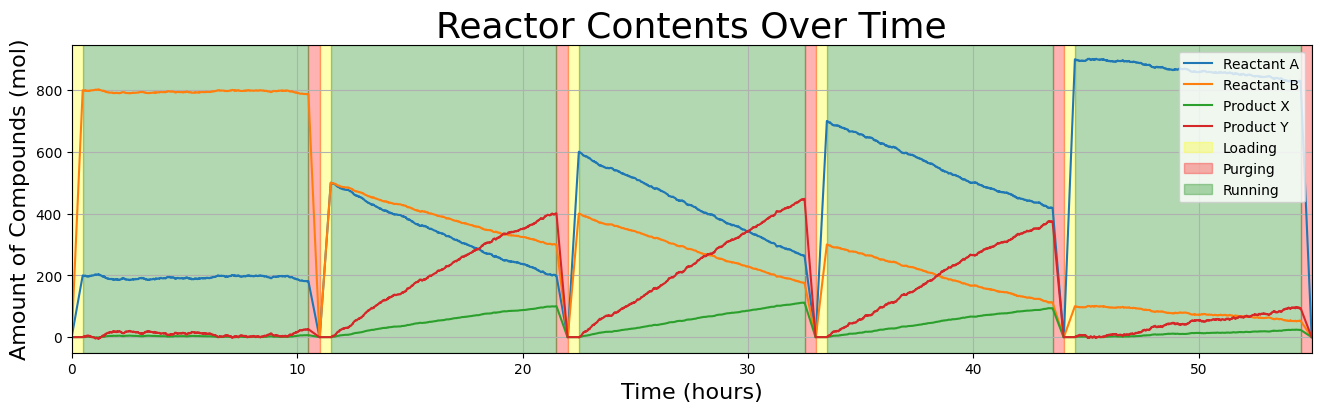

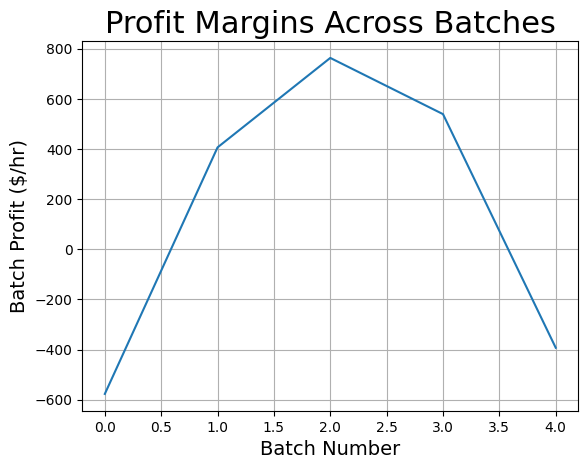

In [ ]:
TEST_REACTOR = Reactor()
TEST_REACTOR.run_batch(200,800,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(500,500,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(600,400,run_time=t_max,run_temp=500) #Perfect stoichiometric ratio
TEST_REACTOR.run_batch(700,300,run_time=t_max,run_temp=500)
TEST_REACTOR.run_batch(900,100,run_time=t_max,run_temp=500)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

Running a reactor at near-stoichiometric ratios, but for different amounts of time.
While the reactor gets closer to completion with longer trials, there is a diminishing return that ultimately influences profitability.

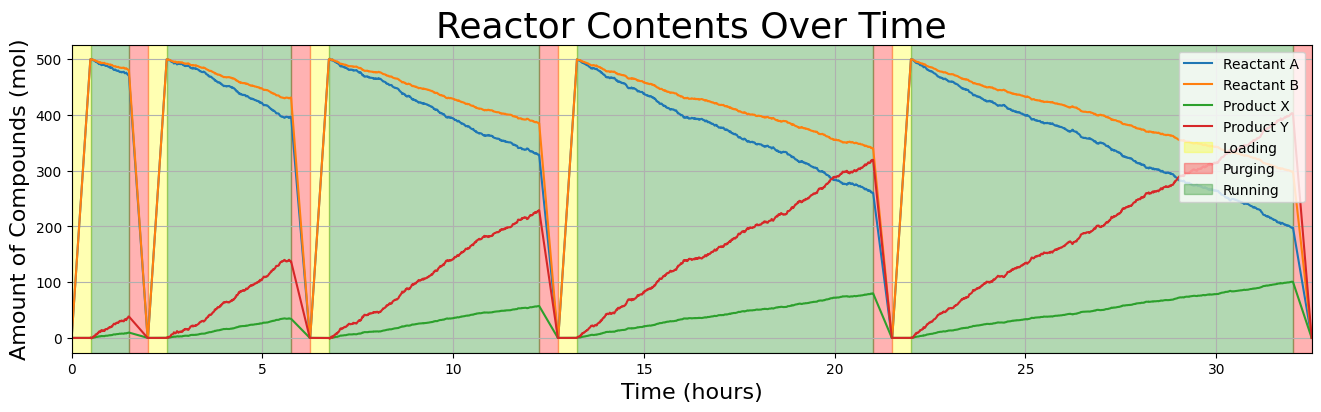

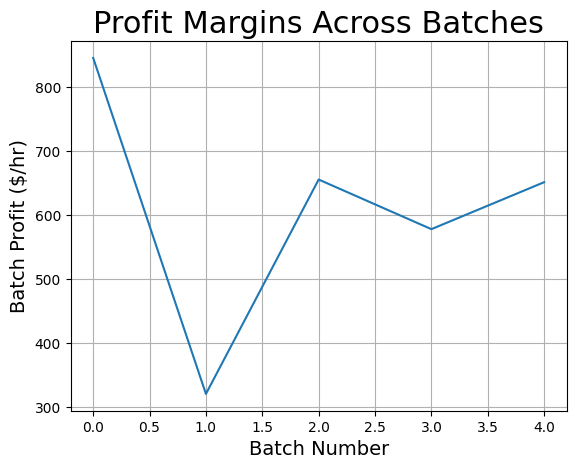

In [ ]:
TEST_REACTOR = Reactor()
for i in np.linspace(t_min,t_max,5,endpoint=True):
    TEST_REACTOR.run_batch(500,500,run_time=i,run_temp=500)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

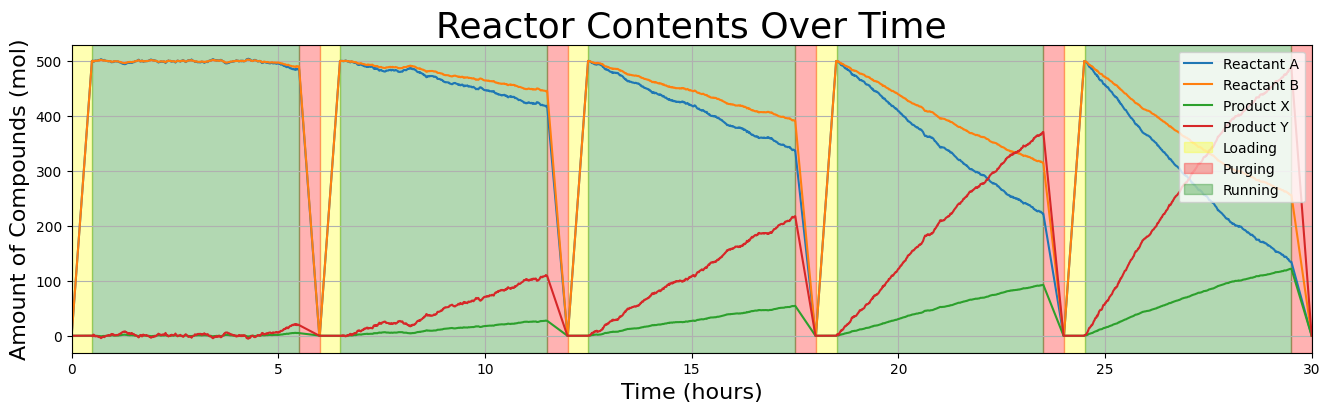

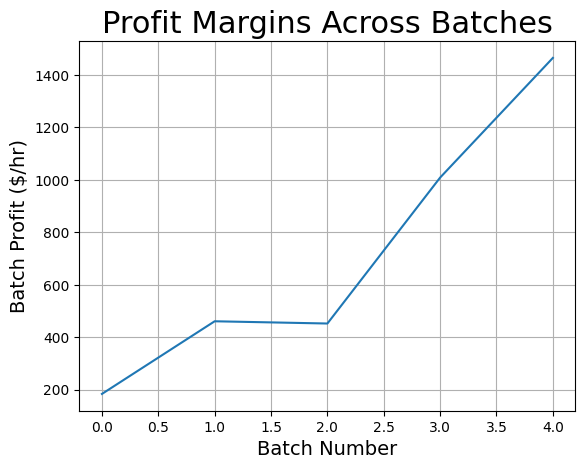

In [ ]:
TEST_REACTOR = Reactor()
for i in np.linspace(T_lower,T_upper,5,endpoint=True):
    TEST_REACTOR.run_batch(500,500,run_time=5,run_temp=i)
TEST_REACTOR._plot_reaction_progress()
TEST_REACTOR._plot_profits()

Considering initial species concentration alongside total reaction time.
This is effectively a brute-force approach, and in practice, running all of these experiments is infeasible in practice.
For these two variables (initial concentration and temperature), students will effectively be optimizing over this noisy surface.

100%|██████████| 80/80 [00:25<00:00,  3.17it/s]


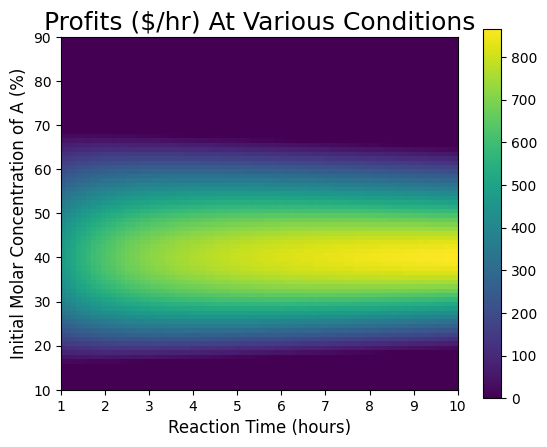

In [ ]:
stoich_time_profits = []
TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(100,900,80,endpoint=True)):
    sub_li = []
    for t in np.linspace(t_min,t_max,80,endpoint=True):
        sub_li.append(TEST_REACTOR.run_batch(i,1000-i,run_time=t,run_temp=500,measure_choice='perfect'))
    stoich_time_profits.append(sub_li)

plt.imshow(stoich_time_profits,extent=[t_min,t_max,10,90],aspect=0.1,vmin=0)
plt.xlabel('Reaction Time (hours)',fontsize=12)
plt.ylabel('Initial Molar Concentration of A (%)',fontsize=12)
plt.title('Profits ($/hr) At Various Conditions',fontsize=18)
plt.colorbar()
plt.show()

100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


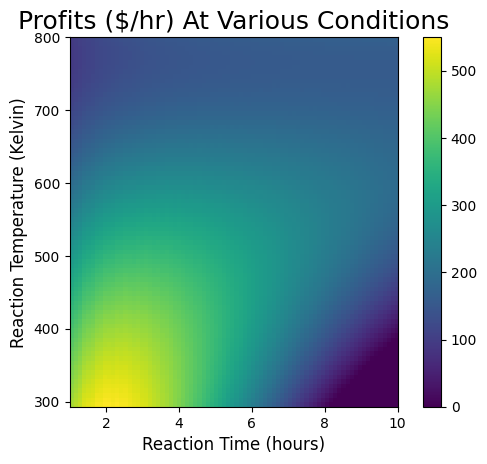

In [ ]:
stoich_time_profits = []
TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(T_lower,T_upper,80,endpoint=True)):
    sub_li = []
    for t in np.linspace(t_min,t_max,80,endpoint=True):
        sub_li.append(TEST_REACTOR.run_batch(400,600,run_time=t,run_temp=i,measure_choice='perfect'))
    stoich_time_profits.append(sub_li)

plt.imshow(stoich_time_profits,extent=[t_min,t_max,T_lower,T_upper],aspect=0.02,vmin=0)
plt.xlabel('Reaction Time (hours)',fontsize=12)
plt.ylabel('Reaction Temperature (Kelvin)',fontsize=12)
plt.title('Profits ($/hr) At Various Conditions',fontsize=18)
plt.colorbar()
plt.show()



100%|██████████| 80/80 [00:00<00:00, 118.96it/s]


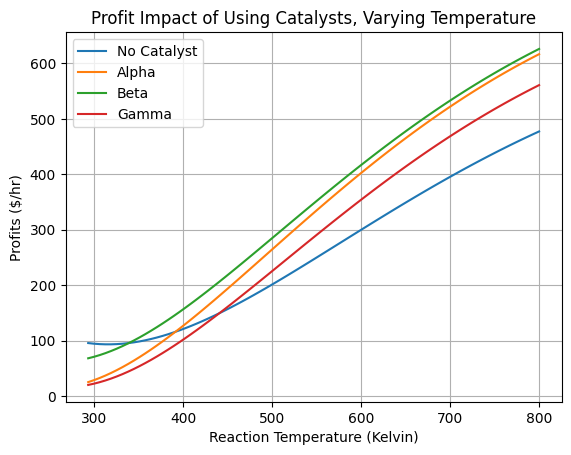

100%|██████████| 80/80 [00:00<00:00, 93.02it/s]


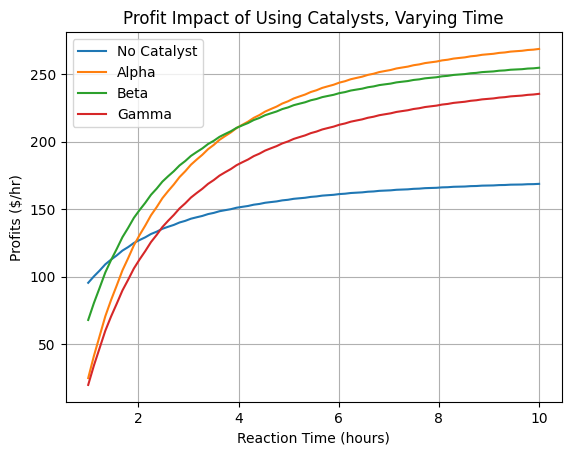

In [ ]:
stoich_time_profits_Cnone = []
stoich_time_profits_Calpha = []
stoich_time_profits_Cbeta = []
stoich_time_profits_Cgamma = []

TEST_REACTOR = Reactor()
TEST_REACTOR.rxn_noise_sigma = 0.0
for i in tqdm(np.linspace(T_lower,T_upper,80,endpoint=True)):
    stoich_time_profits_Cnone.append(TEST_REACTOR.run_batch(400,600,run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Calpha.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='alpha',run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Cbeta.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='beta',run_temp=i,measure_choice='perfect'))
    stoich_time_profits_Cgamma.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='gamma',run_temp=i,measure_choice='perfect'))
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cnone,label='No Catalyst')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Calpha,label='Alpha')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cbeta,label='Beta')
plt.plot(np.linspace(T_lower,T_upper,80,endpoint=True),stoich_time_profits_Cgamma,label='Gamma')
plt.grid()
plt.xlabel('Reaction Temperature (Kelvin)')
plt.ylabel('Profits ($/hr)')
plt.title('Profit Impact of Using Catalysts, Varying Temperature')
plt.legend()
plt.show()

stoich_time_profits_Cnone = []
stoich_time_profits_Calpha = []
stoich_time_profits_Cbeta = []
stoich_time_profits_Cgamma = []

for i in tqdm(np.linspace(t_min,t_max,80,endpoint=True)):
    stoich_time_profits_Cnone.append(TEST_REACTOR.run_batch(400,600,run_time=i,measure_choice='perfect'))
    stoich_time_profits_Calpha.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='alpha',run_time=i,measure_choice='perfect'))
    stoich_time_profits_Cbeta.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='beta',run_time=i,measure_choice='perfect'))
    stoich_time_profits_Cgamma.append(TEST_REACTOR.run_batch(400,600,catalyst_choice='gamma',run_time=i,measure_choice='perfect'))
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cnone,label='No Catalyst')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Calpha,label='Alpha')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cbeta,label='Beta')
plt.plot(np.linspace(t_min,t_max,80,endpoint=True),stoich_time_profits_Cgamma,label='Gamma')
plt.grid()
plt.xlabel('Reaction Time (hours)')
plt.ylabel('Profits ($/hr)')
plt.title('Profit Impact of Using Catalysts, Varying Time')
plt.legend()
plt.show()

In [ ]:
all_processes = []


for temp in tqdm(np.linspace(T_lower,T_upper,20,endpoint=True)):
    for r_time in np.linspace(t_min,t_max,20,endpoint=True):
        TEST_REACTOR = Reactor()
        TEST_REACTOR.rxn_noise_sigma = 0.0
        for stoich in np.linspace(100,900,20,endpoint=True):
            for cat_choice in ['None','alpha','beta','gamma']:
                all_processes.append([temp,r_time,stoich,cat_choice,\
                                    TEST_REACTOR.run_batch(stoich,1000-stoich,catalyst_choice=cat_choice,\
                                    run_temp=temp,run_time=r_time,measure_choice='perfect')])


100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


In [ ]:
print('Best Overall Conditions (Via Brute Force):')
print(all_processes[np.argmax([i[-1] for i in all_processes])])

Best Overall Conditions (Via Brute Force):
[800.0, 5.263157894736842, 605.2631578947369, 'alpha', 2710.4581095798935]


In [ ]:
best_index = np.argmax([process[-1] for process in all_processes])
best_index

31169

### Assignment Rubric
- 20 points: Build a model surrogate with UQ to predict outcomes of particular situations (without running `Reactor()` class)
- 20 points: Design an acquisition function that balances explore versus exploit tradeoffs. Justify your design choices.
- 20 points: Build a process for Bayesian optimization: surrogate predictions --> condition selection --> run reactor --> retrain surrogate --> repeat
- 10 points: Demonstrate how your Bayesian optimization process improves profitability over batches, and quantify the improvement
- 10 points: Demonstrate how changing the explore/exploit tradeoff affects profitability, and quantify the change
- 20 points: Explore and implement some additional considerations or constraints. Be creative! Describe your methods and results in a short report. Some ideas include:
- - What happens if I have two or more reactors that can operate in parallel?
- - What if I am able to run my reactor continuously, rather than across batches?
- - What if the prices of my reactants/products/catalysts were varying every hour, according to a random walk?
- - What if I only have a finite time horizon (eg. a week) to find the best possible reaction conditions?

In [ ]:
# reactor wrapper to make passing parameters easier
# note trained full integers as floats for measure / cat and converted back here
def reactor_wrapper(params):
  measure = ['low_fi','mid_fi','high_fi']
  cat = ['None', 'alpha', 'beta', 'gamma']
  temp, r_time, stoich, cat_choice,measure_choice = params
  cat_choice = cat[int(cat_choice)]
  measure_choice = measure[int(measure_choice)]
  output = TEST_REACTOR.run_batch(stoich, 1000 - stoich, catalyst_choice=cat_choice,
                                  run_temp=temp, run_time=r_time, measure_choice=measure_choice)
  return [params, output]


int_outcome = 0
int_cond = []

# find initial point through grid search (100 reactor calls)
# find best point then use for further Bayesian Optimization
for temp in tqdm(np.linspace(T_lower,T_upper,5,endpoint=True)):
    for r_time in np.linspace(t_min,t_max,5,endpoint=True):
          for cat_choice in (0, 3):
            for measure in (0, 2):
              g_values = np.array([temp,r_time,600,cat_choice,measure])
              c_outcome = reactor_wrapper(g_values)[1]
              if c_outcome > int_outcome:
                int_cond = g_values
                int_outcome = c_outcome


print("\n")
print("best params")
print(int_cond)
print(int_outcome)

100%|██████████| 5/5 [00:00<00:00, 16.46it/s]



best params
[800.    5.5 600.    3.    0. ]
2622.113738203578


In [ ]:
# neural network surrogate model learning reactor function for optimization

class SurrogateModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SurrogateModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.hidden3 = nn.Linear(64, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

# initially trains surrogate model off initial reactor instance
def train_surrogate_model(inputs, outputs):
    X_train = torch.tensor(inputs, dtype=torch.float32)
    y_train = torch.tensor(outputs, dtype=torch.float32)

    input_dim = inputs.shape[1]
    output_dim = outputs.shape[1]
    model = SurrogateModel(input_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 1000
    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

# predicts performance for given params input
def predict_surrogate_model(model, inputs):
    X_test = torch.tensor(inputs, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(X_test).numpy()

    return outputs



# fine_tune surrogate model based on reactor calls from BO
def update_surrogate(model, new_inputs, new_outputs, fine_tune_epochs=100):
    X_fine_tune = torch.tensor(new_inputs, dtype=torch.float32)
    y_fine_tune = torch.tensor(new_outputs, dtype=torch.float32)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(fine_tune_epochs):
        outputs = model(X_fine_tune)
        loss = criterion(outputs, y_fine_tune)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return model


In [ ]:
# bayesian optimization step
def bayesian_optimization(objective_function, bounds, initial_param_values, points_per_batch,model,noise_factor= .1,data_points=1000):

    # acquisition function UCB, returning the best parameters for a given y
    # x data points (1000 instances) are randomly generated within a range of best current Bayesian Parameters
    # y are outputs of the NN model for each of those points
    # std and mu are drawn from data and using acquistion function identify next best params which are returned
    # best data point is then tested in reactor
    def upper_confidence_bound(x,y, sigma=5):
        mu = np.mean(y)
        std = np.std(y)
        ucb_values = mu + std * sigma
        max_index = np.argmax(ucb_values)
        params = [x[0][max_index],x[1][max_index],x[2][max_index],x[3][max_index],x[4][max_index]]
        return list(params)


    current_params = np.array(initial_param_values)
    best_instances = []
    space = []

    # for each point in batch generate and select best point from acquisition function
    for ii in range(points_per_batch):

      # generate random points within each bound with respect to the noise_factor
      for i, bound in enumerate(bounds):
        lower_bound_noise = np.random.normal(-noise_factor * bound[0], noise_factor * bound[0])
        upper_bound_noise = np.random.normal(-noise_factor * bound[1], noise_factor * bound[1])
        lower_interval = current_params[i] + lower_bound_noise
        upper_interval = current_params[i] + upper_bound_noise
        linear_space = np.random.uniform(lower_interval, upper_interval, size=data_points)
        clipped_linear_space = np.clip(linear_space, bound[0], bound[1])
        space.append(clipped_linear_space)

      # train surrogate on points and call acquisition function
      outputs = [predict_surrogate_model(model,params) for params in zip(*(x.flatten() for x in space))]
      b_point = upper_confidence_bound(space,outputs)
      space = []
      best_instances.append(b_point)

    # test best instances for each batch
    outputs = [objective_function(params) for params in best_instances]


    return best_instances, outputs


In [ ]:
#TODO: Flesh out skeleton code for an active learning approach, flesh out brute-force example, show how inefficient it is
#Have students come up with a weak and a strong prior, demonstrating the importance of incorporating prior knowledge into an AL pipeline

# engages full model training
def run_full_process(int_cond,int_outcome,points_per_batch=50,hourcap=320000): # hour cap is used for week runtime in further exploration
  manage_output = []
  bounds = np.array([(T_lower, T_upper),(t_min, t_max), (100, 900), (0, 3),(0,2)])
  c_hours = 0

  def select_conditions(initial_param_values,curr_best,curr_best_params,model):
      #Do something (eg. BO) to select new reactor conditions
      #Run reactor, evaluate results
      params,results = bayesian_optimization(reactor_wrapper, bounds, initial_param_values,points_per_batch,model)

      # update best index if needed
      for sublist_index, sublist in enumerate(results):
          if sublist[1] > curr_best:
              curr_best = sublist[1]
              curr_best_params = sublist[0]


      return curr_best, curr_best_params,params, results


  # initially train surrogate
  model = train_surrogate_model(np.array(int_cond).reshape(1,5), np.array([int_outcome]).reshape(1, 1))
  cond = int_cond
  peformance = []
  total_runs = int(7000/(points_per_batch))
  best_results = int_outcome
  best_params = tuple(int_cond)

  for i in range(total_runs):

    # selection conditons
    best_results,cond,all_params,all_results = select_conditions(cond,best_results,best_params,model)

    # reshape data
    p = [item for sublist in all_params for item in sublist]
    np_params = np.array(p).reshape(points_per_batch,5)
    r = [sublist[1] for sublist in all_results]
    np_results = np.array(r).reshape(points_per_batch,1)
    c_hours+=np.sum(np_params[:, 1])
    manage_output.append([best_results,best_params,(i+1)*(points_per_batch)])

    print("=========================")
    print("price:",best_results)
    print("current reactor runs",(i+1)*(points_per_batch))

    if c_hours > hourcap:
      print("terminating testing at hour:",c_hours);
      break

    # finetune model
    model = update_surrogate(model, np_params, np_results)


  return manage_output


In [ ]:
perf=run_full_process(int_cond,int_outcome)

price: 2698.029349948817
current reactor runs 50
price: 2698.029349948817
current reactor runs 100
price: 2698.029349948817
current reactor runs 150
price: 2698.029349948817
current reactor runs 200
price: 2757.8669291311
current reactor runs 250
price: 2757.8669291311
current reactor runs 300
price: 2757.8669291311
current reactor runs 350
price: 2897.926644320383
current reactor runs 400
price: 2897.926644320383
current reactor runs 450
price: 2897.926644320383
current reactor runs 500
price: 2897.926644320383
current reactor runs 550
price: 2897.926644320383
current reactor runs 600
price: 2897.926644320383
current reactor runs 650
price: 2897.926644320383
current reactor runs 700
price: 2897.926644320383
current reactor runs 750
price: 2897.926644320383
current reactor runs 800
price: 2897.926644320383
current reactor runs 850
price: 2897.926644320383
current reactor runs 900
price: 2897.926644320383
current reactor runs 950
price: 2897.926644320383
current reactor runs 1000
price:

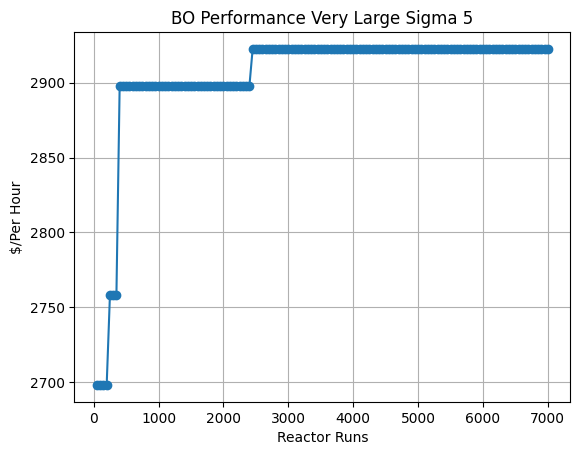

In [ ]:
# GRAPHING IN REACTOR CALLS

x_values = [point[2] for point in perf]
y_values = [point[0] for point in perf]

# Plot the points
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Reactor Runs')
plt.ylabel('$/Per Hour')
plt.title('BO Performance Very Large Sigma 5')

# Show grid
plt.grid(True)

# Show plot
plt.show()

# Exploring Finite Time Horizon
## To achieve this, BO compare model vs brute force and cap behavior at 1 week (roughly 176 hours)


In [ ]:
# optimal brute force after 1 week
all_processes = []

hours = 0

for temp in tqdm(np.linspace(T_lower,T_upper,2,endpoint=True)):
    for r_time in np.linspace(t_min,t_max,2,endpoint=True):
        TEST_REACTOR = Reactor()
        TEST_REACTOR.rxn_noise_sigma = 0.0
        for stoich in np.linspace(100,900,2,endpoint=True):
            for cat_choice in ['None','alpha','beta','gamma']:
              hours+=r_time

              all_processes.append([temp,r_time,stoich,cat_choice,\
                                    TEST_REACTOR.run_batch(stoich,1000-stoich,catalyst_choice=cat_choice,\
                                    run_temp=temp,run_time=r_time,measure_choice='perfect')])
print("\n")
print("total hours:",hours)

100%|██████████| 2/2 [00:00<00:00, 12.93it/s]



total hours: 176.0


In [ ]:
print('Best Overall Conditions (Via Brute Force):')
print(all_processes[np.argmax([i[-1] for i in all_processes])])

Best Overall Conditions (Via Brute Force):
[293.0, 10.0, 900.0, 'beta', 66.25587265252894]


In [ ]:
best_index = np.argmax([process[-1] for process in all_processes])
best_index

14

In [ ]:
int_outcome = 0
int_cond = []
hours_BO = 0

for temp in tqdm(np.linspace(T_lower,T_upper,2,endpoint=True)):
    for r_time in np.linspace(t_min,t_max,2,endpoint=True):
          for cat_choice in (0, 3):
            for measure in (0, 2):
              g_values = np.array([temp,r_time,600,cat_choice,measure])
              c_outcome = reactor_wrapper(g_values)[1]
              hours_BO+=r_time
              if c_outcome > int_outcome:
                int_cond = g_values
                int_outcome = c_outcome




print("\n")
print("total hours:",hours_BO)
print("best params")
print(int_cond)
print(int_outcome)

100%|██████████| 2/2 [00:00<00:00, 12.46it/s]



total hours: 88.0
best params
[800.   1. 600.   3.   0.]
1931.3639124782078


In [ ]:
# running BO with reduced time
perf=run_full_process(int_cond,int_outcome,linspace=5,hourcap=85)

price: 1931.3639124782078
current reactor runs 5
price: 1931.3639124782078
current reactor runs 10
price: 2022.3530897935186
current reactor runs 15
price: 2022.3530897935186
current reactor runs 20
price: 2022.3530897935186
current reactor runs 25
price: 2022.3530897935186
current reactor runs 30
price: 2022.3530897935186
current reactor runs 35
price: 2022.3530897935186
current reactor runs 40
price: 2111.681664068077
current reactor runs 45
price: 2111.681664068077
current reactor runs 50
price: 2111.681664068077
current reactor runs 55
price: 2111.681664068077
current reactor runs 60
price: 2111.681664068077
current reactor runs 65
price: 2111.681664068077
current reactor runs 70
price: 2111.681664068077
current reactor runs 75
price: 2111.681664068077
current reactor runs 80
price: 2111.681664068077
current reactor runs 85
terminating testing at hour: 86.35020675474223
